# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Import dataset

In [ ]:
df = pd.read_csv('drug_od_data')

# Model 1: K-Means Clustering


In [ ]:
# Step 1: Data Preparation
df['Deaths'] = df['Deaths'].astype(str).str.replace(',', '', regex=False).astype(float)
df_region = df[df['Location'] != 'United States']  # Exclude national total

In [ ]:
# Step 2: Pivot table (regions x drugs)
df_pivot = df_region.pivot_table(
    index='Location',
    columns='Drug',
    values='Deaths',
    aggfunc='sum',
    fill_value=0
)
display(df_pivot.head())

Drug,Cocaine,Fentanyl,Gabapentin,Heroin,Methamphetamine,Oxycodone,Xylazine
Location,,,,,,,
Region 1,143234.0,282627.0,21638.0,30540.0,23086.0,19130.0,23934.0
Region 10,28371.0,134374.0,8243.0,32554.0,126239.0,12177.0,1590.0
Region 2,223365.0,412806.0,20947.0,111407.0,35574.0,33566.0,42515.0
Region 3,257877.0,564964.0,25436.0,83600.0,122295.0,35896.0,64031.0
Region 4,356074.0,910289.0,70696.0,108334.0,402101.0,91607.0,35036.0


In [ ]:
# Step 3: K-Means Clustering
model_kmeans = KMeans(n_clusters=4, random_state=42)
df_pivot['Cluster'] = model_kmeans.fit_predict(df_pivot)

In [ ]:
# Step 4: View cluster assignment
display(df_pivot[['Cluster']].sort_values(by='Cluster'))

Drug,Cluster
Location,
Region 3,0
Region 9,0
Region 6,1
Region 10,1
Region 8,1
Region 7,1
Region 2,2
Region 1,2
Region 4,3


In [ ]:
# Step 5: Examine cluster profiles (avg deaths per drug per cluster)
df_profiles = df_pivot.groupby('Cluster').mean().round(2)
display(df_profiles)

Drug,Cocaine,Fentanyl,Gabapentin,Heroin,Methamphetamine,Oxycodone,Xylazine
Cluster,,,,,,,
0,184724.00,504503.50,22884.5,76205.0,283811.0,33406.0,34694.00
1,46747.25,132402.75,10080.0,33259.5,119930.5,15433.5,3176.25
2,183299.50,347716.50,21292.5,70973.5,29330.0,26348.0,33224.50
3,337138.50,826159.50,56771.0,115760.5,305361.5,64187.5,34061.00


In [ ]:
# Step 6: PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_pivot.drop(columns='Cluster'))

df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'], index=df_pivot.index)
df_pca['Cluster'] = df_pivot['Cluster']
df_pca['Region'] = df_pivot.index

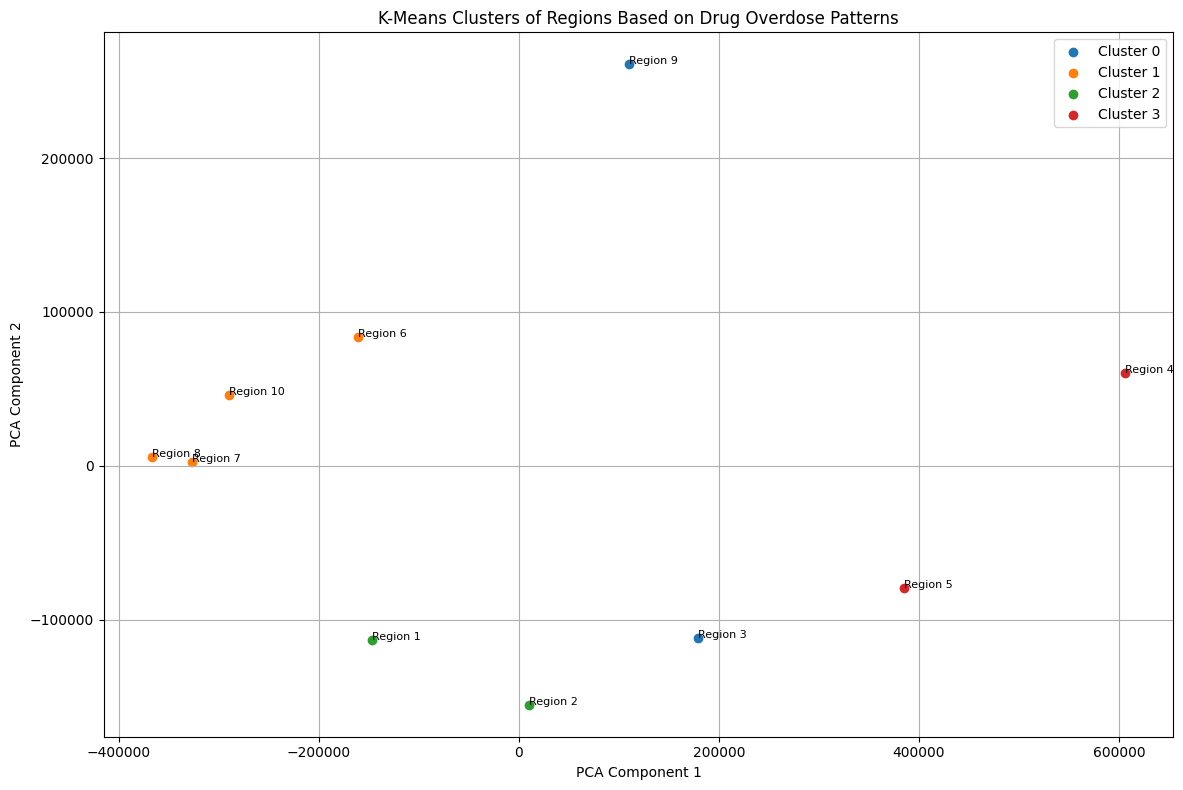

In [ ]:
# Step 7: Plot clusters with region labels
plt.figure(figsize=(12, 8))

for cluster in sorted(df_pca['Cluster'].unique()):
    group = df_pca[df_pca['Cluster'] == cluster]
    plt.scatter(group['PCA1'], group['PCA2'], label=f'Cluster {cluster}')
    for _, row in group.iterrows():
        plt.text(row['PCA1'] + 0.2, row['PCA2'], row['Region'], fontsize=8)

plt.title('K-Means Clusters of Regions Based on Drug Overdose Patterns')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model 2: Apriori Frequent Pattern Mining


In [ ]:
# Step 1: Data Preparation
df['Deaths'] = df['Deaths'].astype(str).str.replace(',', '', regex=False).astype(float)
df_region = df[df['Location'] != 'United States']

# Group drugs by region and time (each basket = drugs reported in a region/month)
df_basket = df_region.groupby(['Location', 'Year', 'Month'])['Drug'] \
                     .apply(list).reset_index(name='Drug_List')
display(df_basket.head())


,Location,Year,Month,Drug_List
0,Region 1,2019,1,"[Fentanyl, Methamphetamine, Cocaine, Heroin, O..."
1,Region 1,2019,2,"[Fentanyl, Methamphetamine, Cocaine, Heroin, O..."
2,Region 1,2019,3,"[Fentanyl, Methamphetamine, Cocaine, Heroin, O..."
3,Region 1,2019,4,"[Fentanyl, Methamphetamine, Cocaine, Heroin, O..."
4,Region 1,2019,5,"[Fentanyl, Methamphetamine, Cocaine, Heroin, O..."


In [ ]:
# Step 2: Transaction Encoding
te = TransactionEncoder()
te_ary = te.fit(df_basket['Drug_List']).transform(df_basket['Drug_List'])
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

display(df_encoded.head())

,Cocaine,Fentanyl,Gabapentin,Heroin,Methamphetamine,Oxycodone,Xylazine
0,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True


In [ ]:
# Step 3: Apply Apriori Algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

display(frequent_itemsets.head(10))

,support,itemsets
0,1.0,(Cocaine)
1,1.0,(Fentanyl)
2,1.0,(Gabapentin)
3,1.0,(Heroin)
4,1.0,(Methamphetamine)
5,1.0,(Oxycodone)
7,1.0,"(Cocaine, Fentanyl)"
11,1.0,"(Cocaine, Oxycodone)"
8,1.0,"(Cocaine, Gabapentin)"
9,1.0,"(Cocaine, Heroin)"


In [ ]:
# Step 4: Generate Association Rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)
rules = rules.sort_values(by='lift', ascending=False)

# Create table
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


,antecedents,consequents,support,confidence,lift
1931,(Gabapentin),"(Cocaine, Oxycodone, Xylazine, Fentanyl, Heroi...",0.948485,0.948485,1.0
0,(Cocaine),(Fentanyl),1.000000,1.000000,1.0
1,(Fentanyl),(Cocaine),1.000000,1.000000,1.0
2,(Cocaine),(Oxycodone),1.000000,1.000000,1.0
3,(Oxycodone),(Cocaine),1.000000,1.000000,1.0
4,(Cocaine),(Gabapentin),1.000000,1.000000,1.0
5,(Gabapentin),(Cocaine),1.000000,1.000000,1.0
6,(Cocaine),(Heroin),1.000000,1.000000,1.0
7,(Heroin),(Cocaine),1.000000,1.000000,1.0
8,(Cocaine),(Methamphetamine),1.000000,1.000000,1.0


# Performance Evaluation for K-Means Clustering

In [ ]:
# Silhouette Score and Davies-Bouldin Index
# Prepare data and labels
X = df_pivot.drop(columns='Cluster')
labels = df_pivot['Cluster']

# Compute metrics
sil_score = silhouette_score(X, labels)
db_index = davies_bouldin_score(X, labels)

# Show results
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")

Silhouette Score: 0.329
Davies-Bouldin Index: 0.841


# Performance Evaluation for Apriori Frequent Pattern Mining

In [ ]:
# Support, confidence, and lift
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)
rules = rules.sort_values(by='lift', ascending=False)

# Create table
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


,antecedents,consequents,support,confidence,lift
1931,(Gabapentin),"(Cocaine, Oxycodone, Xylazine, Fentanyl, Heroi...",0.948485,0.948485,1.0
0,(Cocaine),(Fentanyl),1.000000,1.000000,1.0
1,(Fentanyl),(Cocaine),1.000000,1.000000,1.0
2,(Cocaine),(Oxycodone),1.000000,1.000000,1.0
3,(Oxycodone),(Cocaine),1.000000,1.000000,1.0
4,(Cocaine),(Gabapentin),1.000000,1.000000,1.0
5,(Gabapentin),(Cocaine),1.000000,1.000000,1.0
6,(Cocaine),(Heroin),1.000000,1.000000,1.0
7,(Heroin),(Cocaine),1.000000,1.000000,1.0
8,(Cocaine),(Methamphetamine),1.000000,1.000000,1.0
